# Extract FVCOM time series from aggregated OPeNDAP endpoints 

In [1]:
# Plot time series data from FVCOM model from list of lon,lat locations
# (uses the nearest point, no interpolation)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import datetime as dt
import pandas as pd
from StringIO import StringIO

In [2]:
# make dictionary of various model simulation endpoints
models={}
models['Massbay_forecast']='http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc'
models['GOM3_Forecast']='http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc'
models['Massbay_forecast_archive']='http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/archives/necofs_mb'
models['GOM3_30_year_hindcast']='http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/hindcasts/30yr_gom3'

In [3]:
def start_stop(url,tvar):
    nc = netCDF4.Dataset(url)
    ncv = nc.variables
    time_var = ncv[tvar]
    first = netCDF4.num2date(time_var[0],time_var.units)
    last = netCDF4.num2date(time_var[-1],time_var.units)

    print first.strftime('%Y-%b-%d %H:%M')
    print last.strftime('%Y-%b-%d %H:%M')

In [4]:
tvar = 'time'
for model,url in models.iteritems():
    print model

    try:
        start_stop(url,tvar)
    except:
        print '[problem accessing data]'

GOM3_30_year_hindcast
1978-Jan-01 00:00
2015-Jan-01 00:00
Massbay_forecast_archive
[problem accessing data]
GOM3_Forecast
2016-Aug-15 00:00
2016-Aug-21 00:00
Massbay_forecast
2016-Aug-15 00:00
2016-Aug-21 00:00


In [5]:
#model='Massbay_forecast_archive' 
model='Massbay_forecast'
#model='GOM3_Forecast'
#model='GOM3_30_year_hindcast'
url=models[model]
# Desired time for snapshot
# ....right now (or some number of hours from now) ...
start = dt.datetime.utcnow() - dt.timedelta(hours=72)
stop = dt.datetime.utcnow() + dt.timedelta(hours=72)

# ... or specific time (UTC)
#start = dt.datetime(2004,9,1,0,0,0)
#stop = dt.datetime(2004,11,1,0,0,0)

In [6]:
def dms2dd(d,m,s):
    return d+(m+s/60.)/60.
  

In [7]:
dms2dd(41,33,15.7)
dms2dd(42,51,17.40)

42.85483333333333

In [8]:
-dms2dd(70,30,20.2)
-dms2dd(70,18,42.0)

-70.31166666666667

In [9]:
x = '''
Station, Lat, Lon
Falmouth Harbor,    41.541575, -70.608020
Sage Lot Pond, 41.554361, -70.505611
'''

In [10]:
x = '''
Station, Lat, Lon
Boston,             42.368186, -71.047984
Carolyn Seep Spot,    39.8083, -69.5917
Falmouth Harbor,  41.541575, -70.608020
'''

In [11]:
# Enter desired (Station, Lat, Lon) values here:
x = '''
Station, Lat, Lon
Boston,             42.368186, -71.047984
Scituate Harbor,    42.199447, -70.720090
Scituate Beach,     42.209973, -70.724523
Falmouth Harbor,    41.541575, -70.608020
Marion,             41.689008, -70.746576
Marshfield,         42.108480, -70.648691
Provincetown,       42.042745, -70.171180
Sandwich,           41.767990, -70.466219
Hampton Bay,        42.900103, -70.818510
Gloucester,         42.610253, -70.660570
'''

In [12]:
x = '''
Station, Lat, Lon
Buoy A,             42.52280, -70.56535
Buoy B,             43.18089, -70.42788
Nets,               42.85483, -70.3116
DITP,               42.347  , -70.960
'''

In [13]:
# Create a Pandas DataFrame
obs=pd.read_csv(StringIO(x.strip()), sep=",\s*",index_col='Station',engine='python')

In [14]:
obs

,Lat,Lon
Station,,
Buoy A,42.52280,-70.56535
Buoy B,43.18089,-70.42788
Nets,42.85483,-70.31160
DITP,42.34700,-70.96000


In [15]:
# find the indices of the points in (x,y) closest to the points in (xi,yi)
def nearxy(x,y,xi,yi):
    ind = np.ones(len(xi),dtype=int)
    for i in np.arange(len(xi)):
        dist = np.sqrt((x-xi[i])**2+(y-yi[i])**2)
        ind[i] = dist.argmin()
    return ind

In [16]:
nc=netCDF4.Dataset(url)

In [17]:
# open NECOFS remote OPeNDAP dataset 
ncv = nc.variables

In [18]:
# find closest NECOFS nodes to station locations
obs['0-Based Index'] = nearxy(ncv['lon'][:],ncv['lat'][:],obs['Lon'],obs['Lat'])
obs

,Lat,Lon,0-Based Index
Station,,,
Buoy A,42.52280,-70.56535,5507
Buoy B,43.18089,-70.42788,256
Nets,42.85483,-70.31160,1008
DITP,42.34700,-70.96000,59458


In [19]:
ncv['lon'][0:10]

array([-70.56564331, -70.54589081, -70.52242279, -70.49489594,
       -70.46069336, -70.42356873, -70.38311005, -70.3338089 ,
       -70.2835083 , -70.23035431], dtype=float32)

In [20]:
# get time values and convert to datetime objects
time_var = ncv['time']
istart = netCDF4.date2index(start,time_var,select='nearest')
istop = netCDF4.date2index(stop,time_var,select='nearest')
jd = netCDF4.num2date(time_var[istart:istop],time_var.units)

In [37]:
# get all time steps of water level from each station
# NOTE: this takes a while....
nsta=len(obs)
z = np.ones((len(jd),nsta))
layer = 0  # surface layer =0, bottom layer=-1
for i in range(nsta):
    z[:,i] = ncv['temp'][istart:istop,layer,obs['0-Based Index'][i]]
    

In [38]:
# make a DataFrame out of the interpolated time series at each location
zvals=pd.DataFrame(z*9./5.+32.,index=jd,columns=obs.index)

In [39]:
# list out a few values
zvals.head()

Station,Buoy A,Buoy B,Nets,DITP
2016-08-15 19:01:52.500,69.375790,67.246623,69.177295,71.326307
2016-08-15 19:58:07.500,69.398172,67.139050,69.095519,70.828001
2016-08-15 21:00:00.000,69.328443,66.979741,68.992168,71.621949
2016-08-15 22:01:52.500,69.159799,66.767914,68.858571,71.673821
2016-08-15 22:58:07.500,68.919734,66.518329,68.689450,71.483785


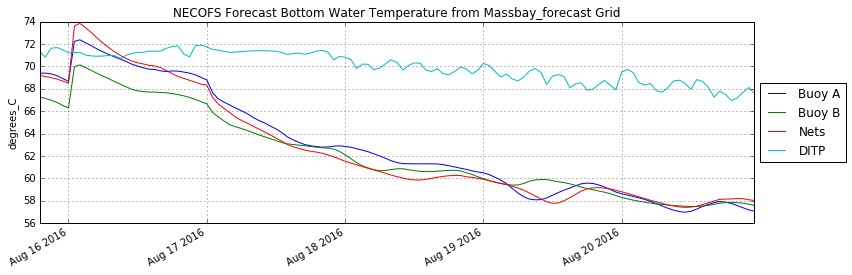

In [40]:
# plotting at DataFrame is easy!
ax=zvals.plot(figsize=(16,4),grid=True,
    title=('NECOFS Forecast Bottom Water Temperature from %s Grid' % model),legend=False);
# read units from dataset for ylabel
plt.ylabel(ncv['temp'].units)
# plotting the legend outside the axis is a bit tricky
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));


In [41]:
# make a new DataFrame of maximum water levels at all stations
b=pd.DataFrame(zvals.idxmax(),columns=['time of max water temp (UTC)'])
# create heading for new column containing max water level
zmax_heading='tmax (%s)' % ncv['temp'].units
# Add new column to DataFrame
b[zmax_heading]=zvals.max()

In [42]:
b

,time of max water temp (UTC),tmax (degrees_C)
Station,,
Buoy A,2016-08-16 01:58:07.500,72.371106
Buoy B,2016-08-16 01:58:07.500,70.135093
Nets,2016-08-16 01:58:07.500,73.831203
DITP,2016-08-16 22:58:07.500,71.891186
